In [3]:
#import necessary lib
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import util
from util import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Naive Bayes Model libs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [67]:
from google.colab import files
uploaded = files.upload()  #running in google colab


Saving cleaned_data.csv to cleaned_data (1).csv
Saving file.csv to file.csv


In [3]:
data_clean=pd.read_csv('cleaned_data.csv')   #Read the clean data   
data_clean.head()

,tweets,labels,encoded_label
0,optimize language model dialogue,neutral,1
1,try talk new ai system optimize dialogue feedb...,good,2
2,optimize language model dialogue ai machinelea...,neutral,1
3,thrilled share new model optimize dialog publi...,good,2
4,minute ago release new innand use right,bad,0


In [4]:
data_clean['labels'].value_counts()

labels
bad        106513
good        55655
neutral     55087
Name: count, dtype: int64

Plot saved to data_clean_unbalanced


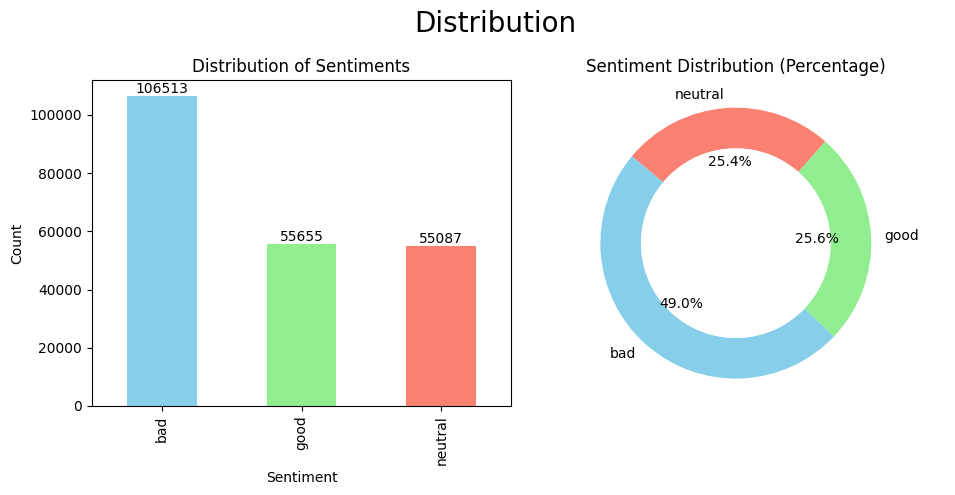

In [5]:
plot_sentiment_distribution(data_clean,'data_clean_unbalanced')    #distribution of unbalanced data

In [6]:
#balancing data with RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
x, y = rus.fit_resample(np.array(data_clean['tweets']).reshape(-1, 1), np.array(data_clean['labels']).reshape(-1, 1))

data_clean_balanced = pd.DataFrame(list(zip([x[0] for x in x], y)), columns=['tweets', 'labels'])
data_clean_balanced.head()

,tweets,labels
0,ask write poem fail omnichannel executive appl...,bad
1,revolutionary thing human history,bad
2,sell soul devil try chatgptinnthe whole browsi...,bad
3,I be actual disbelive good wtf,bad
4,wait jest test run today give openais spin,bad


Plot saved to data_clean_balanced


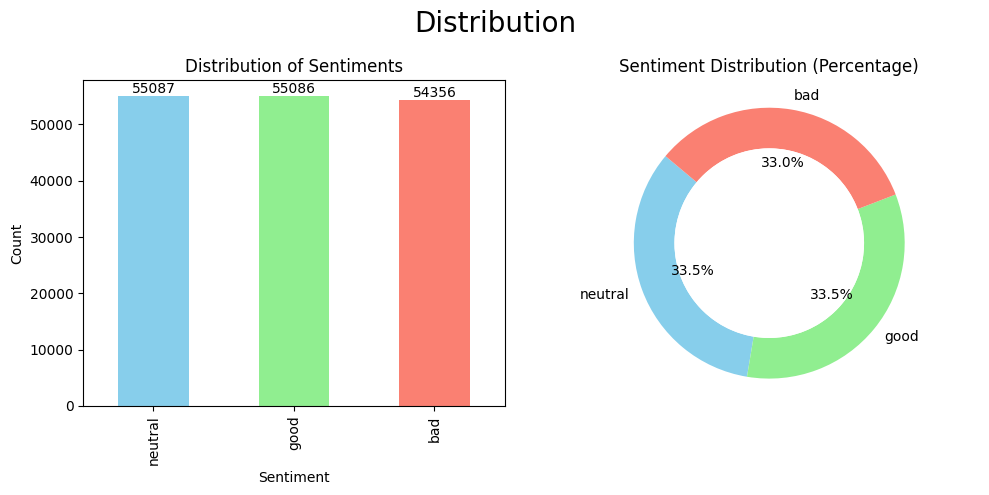

In [71]:
plot_sentiment_distribution(data_clean_balanced,'data_clean_balanced')   #distribution of balanced data (Using undersampling)

In [7]:
mapping = {
    'bad': 0,
    'neutral': 1,
    'good': 2,
}
data_clean_balanced['encoded_label'] = data_clean_balanced['labels'].map(mapping)


In [8]:
data_clean_balanced['encoded_label'].value_counts()

encoded_label
0    55087
2    55087
1    55087
Name: count, dtype: int64

In [9]:
data_clean_balanced.dropna(inplace=True)   # check for NA 
data_clean_balanced.isna().sum()

tweets           0
labels           0
encoded_label    0
dtype: int64

In [10]:
#data Preparing train, validation and test
X = data_clean_balanced['tweets'].values
y = data_clean_balanced['encoded_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)   #random_state=42
X_train, X_valid, y_train, y_valid=train_test_split(X_train, y_train, test_size=0.15, random_state=42)   #random_state=42



In [11]:
#One hot encoding 
from sklearn import preprocessing
#copy the data
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

ohe = preprocessing.OneHotEncoder()    #onehotencoder
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [18]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 118871
VALIDATION DATA: 20978
TESTING DATA: 24680


In [12]:
##Naive Bayes Model
#CountVectorizer
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

#feature extraction
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)
nb_pred = nb_clf.predict(X_test_tf)

              precision    recall  f1-score   support

           0       0.84      0.55      0.67      8082
           1       0.55      0.45      0.50      8352
           2       0.54      0.82      0.65      8251

    accuracy                           0.61     24685
   macro avg       0.64      0.61      0.60     24685
weighted avg       0.64      0.61      0.60     24685



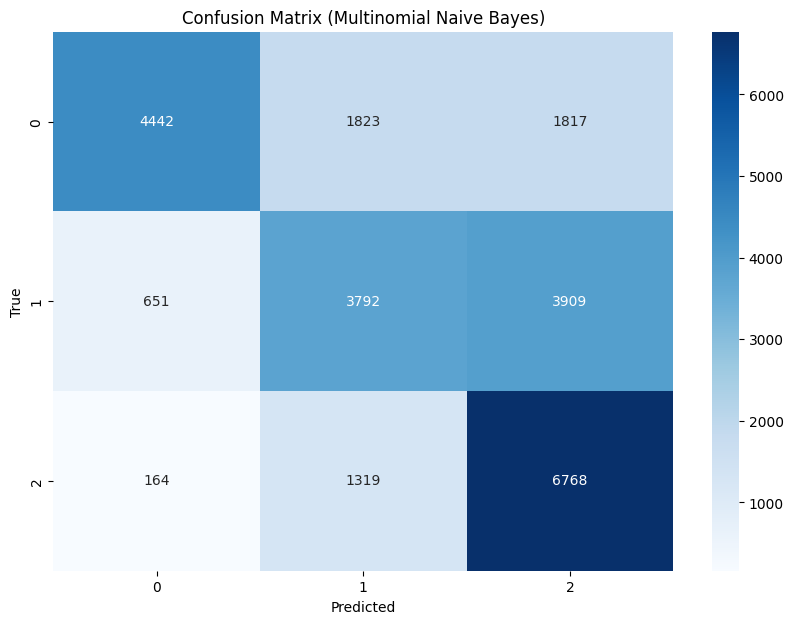

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_test_le, nb_pred)  #confusion matrix

# classification report
class_report = classification_report(y_test_le, nb_pred)
print(class_report)

#CF plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multinomial Naive Bayes)')

plt.savefig('MNB_heatmap.png')

plt.show()